# Project 5: 
# Expedia Hotel Recommendations
## Which hotel type will an Expedia customer book?

## Appendix:

### Table of Contents:

1. [TensorFlow Recommendation System (Basic Retrieve Model)](#1.-TensorFlow-Recommendation-System---Basic-Retrieve-Model)  
    1. [Preparing input (10 classes / 100,000 data)](#a.-Preparing-input---10-classes-/-100,000-data)  
    1. [Basic Retrieval Model](#b.-Basic-Retrieval-Model) 
1. [Tensorflow Recommendation System (Advanced Model)](#2.-Tensorflow-Recommendation-System---Advanced-Model) 
    1. [Smaller Dataset - 10 categories](#a.-Smaller-Dataset---10-categories) 
    1. [Preparing input - Full Dataset](#b.-Preparing-input---Full-Dataset) 
    1. [Advanced Retrieval Model -  Added Features](#c.-Advanced-Retrieval-Model---Added-Features) 
1. [Evaluation](#3.-Evaluation) 

In [1]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime


import ml_metrics as ml_metrics

#### Loading in the Data

In [2]:
data = pd.read_csv('../datasets/train_clean.csv')
kaggle = pd.read_csv('../datasets/test_clean.csv')

In [3]:
# making sure the data and kaggle set have the same dtypes
kaggle['days_to_checkin'] = kaggle['days_to_checkin'].astype('int64')
kaggle['stay_length'] = kaggle['stay_length'].astype('int64')
kaggle['month_of_staying'] = kaggle['month_of_staying'].astype('int64')

#### Preprocessing Functions

In [4]:
# initial preprocessing

def preprocessing(df):
    
    #change to only year
    df['date_time'] = pd.to_datetime(df['date_time'], format = '%Y-%m-%d').dt.year 
    
    # if number of adult is 0, normally it means 1:
    df['srch_adults_cnt'] = df['srch_adults_cnt'].map(lambda x: 1 if x == 0 else x)
    
    # if number of room is 0, normally it means 1:
    df['srch_rm_cnt'] = df['srch_rm_cnt'].map(lambda x: 1 if x == 0 else x)

    #categorise to 1 for short stay (1 day), 2 for normal stay (2 days to a week) and 3 for long stay (more than a week)
    df['stay_length'] = df['stay_length'].map(lambda x: 1 if x<=1 else(2 if x in range(2, 8) else 3))
    
    #categorise to 1 for urgent booking (1 day), 2 for normal booking (2 days to a month in advance) and 3 for advance booking (more than a month prior)
    df['days_to_checkin']= df['days_to_checkin'].map(lambda x: 1 if x<=1 else(2 if x in range(2, 30) else 3))
    
    return df

data = preprocessing(data)
kaggle = preprocessing(kaggle)

In [5]:
# import libraries for tensorflow

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Embedding
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import utils
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
from tensorflow.keras.optimizers import Adam
import tensorflow_recommenders as tfrs
%load_ext tensorboard
import tensorboard

from typing import Dict, Text

import logging
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.FATAL)

## 1. TensorFlow Recommendation System - Basic Retrieve Model

### a. Preparing input - 10 classes / 100,000 data

In [6]:
#subset if needed

most_popular_hotel_clusters = list(data['hotel_cluster'].value_counts()[0:10].index)
data_sub = data[data['hotel_cluster'].map(lambda x: x in most_popular_hotel_clusters)]
data_sub = data_sub[:100_000]

preference = data_sub[['user_id', 'hotel_cluster']].astype(str)
hotel_cluster = data_sub[['hotel_cluster']].astype(str)

In [7]:
preference.head()

,user_id,hotel_cluster
4,1482,95
5,1482,95
6,1482,95
17,3313,91
19,3925,42


In [8]:
hotel_cluster.head()

,hotel_cluster
4,95
5,95
6,95
17,91
19,42


In [9]:
hotel_cluster.value_counts()

hotel_cluster
91               17688
48               12721
42               10676
59                9660
28                9282
16                8225
18                8068
50                7947
95                7943
82                7790
dtype: int64

In [10]:
# changing data to tf.Dataset format

preference = tf.data.Dataset.from_tensor_slices(dict(preference))
preference = preference.map(lambda x: {'hotel_cluster': x['hotel_cluster'],
                                         'user_id': x['user_id']
                                        }
                             )

unique = hotel_cluster['hotel_cluster'].unique()
unique = pd.DataFrame(unique)
unique.columns = ['hotel_cluster']
hotel_cluster = tf.data.Dataset.from_tensor_slices(dict(unique))
hotel_cluster = hotel_cluster.map(lambda x: x['hotel_cluster'])

In [11]:
list(preference.as_numpy_iterator())[:5]

[{'hotel_cluster': b'95', 'user_id': b'1482'},
 {'hotel_cluster': b'95', 'user_id': b'1482'},
 {'hotel_cluster': b'95', 'user_id': b'1482'},
 {'hotel_cluster': b'91', 'user_id': b'3313'},
 {'hotel_cluster': b'42', 'user_id': b'3925'}]

In [12]:
list(hotel_cluster.as_numpy_iterator())[:5]

[b'95', b'91', b'42', b'18', b'82']

In [13]:
#creating vocabulary for model
user_ids = preference.batch(100_000).map(lambda x: x['user_id'])
hotel_cluster_ids = hotel_cluster.batch(1_000)

unique_user_ids = np.unique(np.concatenate(list(user_ids)))
unique_hotel_clusters = np.unique(np.concatenate(list(hotel_cluster_ids)))

In [14]:
unique_user_ids

array([b'1000005', b'1000026', b'1000035', ..., b'999913', b'999943',
       b'999971'], dtype=object)

In [15]:
unique_hotel_clusters

array([b'16', b'18', b'28', b'42', b'48', b'50', b'59', b'82', b'91',
       b'95'], dtype=object)

In [16]:
# train_test_split

tf.random.set_seed(16)

datasize = len(data_sub)
test_ratio = 0.25
train_size = int((1- test_ratio) * datasize)
test_size = int(test_ratio * datasize)

shuffled = preference.shuffle(datasize, seed=16, reshuffle_each_iteration=False)
train = shuffled.take(train_size)
test = shuffled.skip(train_size).take(test_size)

### b. Basic Retrieval Model

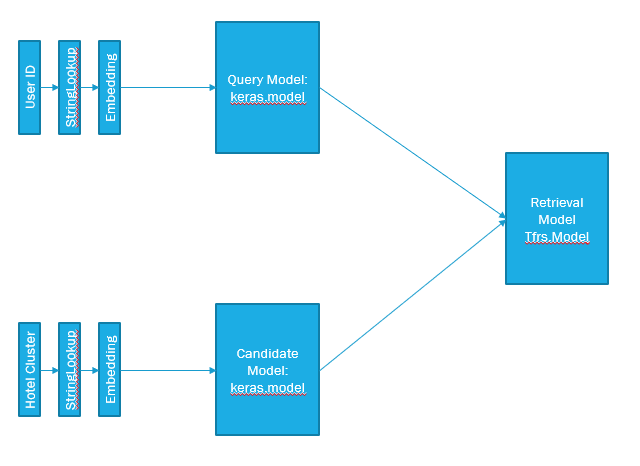

In [17]:
# instantiate query and candidate models for input
embedding_dimension = 32

# Query Tower
user_model = Sequential([StringLookup(vocabulary = unique_user_ids, mask_token = None),
                         Embedding(len(unique_user_ids) + 1, embedding_dimension)
                        ])

# Candidate Tower
hotel_cluster_model = Sequential([StringLookup(vocabulary = unique_hotel_clusters, mask_token = None),
                                  Embedding(len(unique_hotel_clusters) + 1, embedding_dimension)
                                 ])

# metric as top K categorical accuracy
metrics = tfrs.metrics.FactorizedTopK(candidates = hotel_cluster.batch(128).map(hotel_cluster_model))
                                      
task = tfrs.tasks.Retrieval(metrics = metrics);

In [18]:
# instantiate recommender model

class RetrievalModel(tfrs.Model):
    
    def __init__(self, 
                 user_model: tf.keras.Model, 
                 hotel_cluster_model: tf.keras.Model
                 ):
        
        super().__init__()
        self.hotel_cluster_model = hotel_cluster_model
        self.user_model = user_model
        self.task = task
            
    def compute_loss(self, 
                     features: Dict[Text,tf.Tensor], 
                     training=False) -> tf.Tensor:
        
        user_embeddings = self.user_model(features['user_id'])
        positive_hotel_embeddings = self.hotel_cluster_model(features['hotel_cluster'])

        # The task computes the loss and the metrics.
        return self.task(user_embeddings, positive_hotel_embeddings)

In [19]:
cached_train = train.shuffle(datasize).batch(8192).cache()
cached_test = test.batch(4096).cache()

model = RetrievalModel(user_model, hotel_cluster_model)

In [20]:
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

In [21]:
history = model.fit(cached_train, validation_data=cached_test, epochs=3, batch_size = 512)

Epoch 1/3
10/10 [==============================] - 7s 597ms/step - factorized_top_k/top_1_categorical_accuracy: 0.1177 - factorized_top_k/top_5_categorical_accuracy: 0.5347 - factorized_top_k/top_10_categorical_accuracy: 0.9706 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 61672.3118 - regularization_loss: 0.0000e+00 - total_loss: 61672.3118 - val_factorized_top_k/top_1_categorical_accuracy: 0.1577 - val_factorized_top_k/top_5_categorical_accuracy: 0.6054 - val_factorized_top_k/top_10_categorical_accuracy: 0.9789 - val_factorized_top_k/top_50_categorical_accuracy: 1.0000 - val_factorized_top_k/top_100_categorical_accuracy: 1.0000 - val_loss: 2500.2275 - val_regularization_loss: 0.0000e+00 - val_total_loss: 2500.2275
Epoch 2/3
10/10 [==============================] - 5s 512ms/step - factorized_top_k/top_1_categorical_accuracy: 0.3801 - factorized_top_k/top_5_categorical_accuracy: 0.9349 - factorized_top_k/top_10_ca

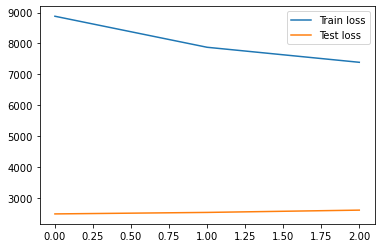

In [22]:
plt.plot(history.history['loss'], label = 'Train loss')
plt.plot(history.history['val_loss'], label = 'Test loss')
plt.legend();

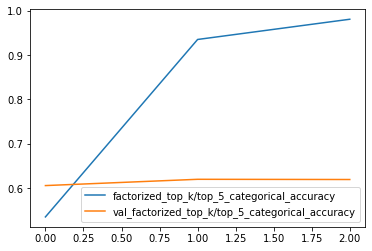

In [23]:
plt.plot(history.history['factorized_top_k/top_5_categorical_accuracy'], label = 'factorized_top_k/top_5_categorical_accuracy')
plt.plot(history.history['val_factorized_top_k/top_5_categorical_accuracy'], label = 'val_factorized_top_k/top_5_categorical_accuracy')
plt.legend();

In [24]:
model.evaluate(cached_test, return_dict=True)

7/7 [==============================] - 1s 94ms/step - factorized_top_k/top_1_categorical_accuracy: 0.1624 - factorized_top_k/top_5_categorical_accuracy: 0.6191 - factorized_top_k/top_10_categorical_accuracy: 0.9770 - factorized_top_k/top_50_categorical_accuracy: 1.0000 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 26877.3431 - regularization_loss: 0.0000e+00 - total_loss: 26877.3431


{'factorized_top_k/top_1_categorical_accuracy': 0.16235999763011932,
 'factorized_top_k/top_5_categorical_accuracy': 0.6190800070762634,
 'factorized_top_k/top_10_categorical_accuracy': 0.9770399928092957,
 'factorized_top_k/top_50_categorical_accuracy': 1.0,
 'factorized_top_k/top_100_categorical_accuracy': 1.0,
 'loss': 2622.34521484375,
 'regularization_loss': 0,
 'total_loss': 2622.34521484375}

In [25]:
# Use brute-force search to set up retrieval using the trained representations.
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
index.index(hotel_cluster.batch(1000).map(model.hotel_cluster_model), hotel_cluster)

# Get some recommendations.
score, recommend = index(tf.constant(['94390']))
print(f"Top 5 recommendations for user 94390: {recommend[0, :5]}")
print(f'Scores for top 5: {score[0, :5]}')

Top 5 recommendations for user 94390: [b'18' b'42' b'48' b'59' b'91']
Scores for top 5: [2.1793728  0.8887844  0.7949772  0.64180493 0.47804558]


#### Predict for Kaggle (Only Run if Wanted to save file for Kaggle Submission)

In [26]:
def convert_to_kaggleformat(index, kaggle):
    
    def gettop5(user):        
        _, recommend = index(tf.constant([user]))
        top5 = [x.decode('utf-8') for x in np.array(recommend[0, :5])]
        pred = ' '.join(top5)
        return pred
    
    submit = kaggle[['id']].copy(deep = True)
    submit['hotel_cluster']= kaggle.apply(lambda x: gettop5(x['user_id'].astype(str)), axis = 1)
    
    return submit

In [27]:
# submit = convert_to_kaggleformat(index, kaggle)
# submit.to_csv('../datasets/submission_tfrs.csv', index = False)

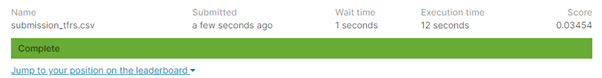

This retrival model only scored 0.03454 on Kaggle. This is lower than the baseline score. We are not concerned as we haven't used the full dataset nor run the model on more epochs but also it shows that more work needs to be done than just a simple retrieve model with only user_id and hotel_clusters

## 2. Tensorflow Recommendation System - Advanced Model

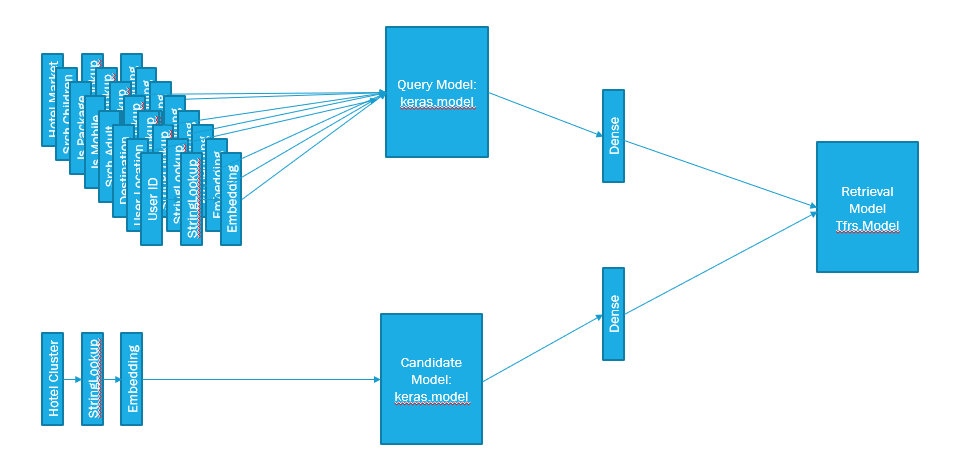

### a. Smaller Dataset - 10 categories

A smaller Dataset was ran earlier and the model saved. The code is edited to run for the full dataset in section b and c below under full dataset. We shall only load the model here to present the results.

In [28]:
#subset if needed

most_popular_hotel_clusters = list(data['hotel_cluster'].value_counts()[:10].index)
data_sub = data[data['hotel_cluster'].map(lambda x: x in most_popular_hotel_clusters)]
data_sub = data_sub[:100_000]

preference = data_sub.drop(['date_time','cnt'], axis = 1).astype(str)
hotel_cluster = data_sub[['hotel_cluster']].astype(str)

In [29]:
# changing data to tf.Dataset format

preference = tf.data.Dataset.from_tensor_slices(dict(preference))
preference = preference.map(lambda x: {'hotel_cluster': x['hotel_cluster'],
                                       'user_id': x['user_id'],
                                       'user_location_city': x['user_location_city'],
                                       'is_mobile': x['is_mobile'],
                                       'is_package': x['is_package'],
                                       'channel': x['channel'],
                                       'srch_adults_cnt': x['srch_adults_cnt'],
                                       'srch_children_cnt': x['srch_children_cnt'],
                                       'srch_rm_cnt': x['srch_rm_cnt'],
                                       'srch_destination_id': x['srch_destination_id'],
                                       'hotel_market': x['hotel_market'],
                                       'days_to_checkin': x['days_to_checkin'],
                                       'stay_length': x['stay_length'],
                                       'month_of_booking': x['month_of_booking'],
                                       'month_of_staying': x['month_of_staying']
                                      }
                           )

unique = hotel_cluster['hotel_cluster'].unique()
unique = pd.DataFrame(unique)
unique.columns = ['hotel_cluster']
hotel_cluster = tf.data.Dataset.from_tensor_slices(dict(unique))
hotel_cluster = hotel_cluster.map(lambda x: x['hotel_cluster'])

In [30]:
# train_test_split

tf.random.set_seed(16)

datasize = len(data_sub)
test_ratio = 0.25
train_size = int((1- test_ratio) * datasize)
test_size = int(test_ratio * datasize)

shuffled = preference.shuffle(datasize, seed=16, reshuffle_each_iteration=False)
train = shuffled.take(train_size)
test = shuffled.skip(train_size).take(test_size)

cached_train = train.shuffle(datasize).batch(8192).cache()
cached_test = test.batch(4096).cache()

In [31]:
smallset = tf.keras.models.load_model('../models/TFRS_10_class/')

In [32]:
def convert_tensor_to_mapX_format(index, test): 

    '''
    Function to map output of BruteForce Layer to nested list format for input to ML Metrics
    
    '''
    
    df = test.map(lambda x: {'user_id': x['user_id'],
                             'user_location_city': x['user_location_city'],
                             'is_mobile': x['is_mobile'],
                             'is_package': x['is_package'],
                             'channel': x['channel'],
                             'srch_adults_cnt': x['srch_adults_cnt'],
                             'srch_children_cnt': x['srch_children_cnt'],
                             'srch_rm_cnt': x['srch_rm_cnt'],
                             'srch_destination_id': x['srch_destination_id'],
                             'hotel_market': x['hotel_market'],
                             'days_to_checkin': x['days_to_checkin'],
                             'stay_length': x['stay_length'],
                             'month_of_booking': x['month_of_booking'],
                             'month_of_staying': x['month_of_staying']
                              }
                   )
    prediction = []

    for row in df.batch(8192):
        top = index(row)[1].numpy()[:, :5]
        prediction += pd.DataFrame(top).apply(lambda x: [x[i].decode('utf-8') for i in range(len(x))], axis = 1).tolist()    
    
    return prediction

In [33]:
predictions = convert_tensor_to_mapX_format(smallset, train)
target = train.map(lambda x: x['hotel_cluster'])
target = list(target.as_numpy_iterator())
target = [[x.decode('utf-8')] for x in target]
print(f'Trainset MAP@5 score: {ml_metrics.mapk(target, predictions, k=5)}')

Trainset MAP@5 score: 0.9675977777777777


In [34]:
predictions = convert_tensor_to_mapX_format(smallset, test)
target = test.map(lambda x: x['hotel_cluster'])
target = list(target.as_numpy_iterator())
target = [[x.decode('utf-8')] for x in target]
print(f'Testset MAP@5 score: {ml_metrics.mapk(target, predictions, k=5)}')

Testset MAP@5 score: 0.569474


### b. Preparing input - Full Dataset

In [35]:
#subset if needed

most_popular_hotel_clusters = list(data['hotel_cluster'].value_counts()[:].index)
data_sub = data[data['hotel_cluster'].map(lambda x: x in most_popular_hotel_clusters)]
data_sub = data_sub[:]

preference = data_sub.drop(['date_time','cnt'], axis = 1).astype(str)
hotel_cluster = data_sub[['hotel_cluster']].astype(str)

In [36]:
# changing data to tf.Dataset format

preference = tf.data.Dataset.from_tensor_slices(dict(preference))
preference = preference.map(lambda x: {'hotel_cluster': x['hotel_cluster'],
                                       'user_id': x['user_id'],
                                       'user_location_city': x['user_location_city'],
                                       'is_mobile': x['is_mobile'],
                                       'is_package': x['is_package'],
                                       'channel': x['channel'],
                                       'srch_adults_cnt': x['srch_adults_cnt'],
                                       'srch_children_cnt': x['srch_children_cnt'],
                                       'srch_rm_cnt': x['srch_rm_cnt'],
                                       'srch_destination_id': x['srch_destination_id'],
                                       'hotel_market': x['hotel_market'],
                                       'days_to_checkin': x['days_to_checkin'],
                                       'stay_length': x['stay_length'],
                                       'month_of_booking': x['month_of_booking'],
                                       'month_of_staying': x['month_of_staying']
                                      }
                           )

unique = hotel_cluster['hotel_cluster'].unique()
unique = pd.DataFrame(unique)
unique.columns = ['hotel_cluster']
hotel_cluster = tf.data.Dataset.from_tensor_slices(dict(unique))
hotel_cluster = hotel_cluster.map(lambda x: x['hotel_cluster'])

### c. Advanced Retrieval Model - Added Features

In [37]:
class QueryModel(tf.keras.Model):
    
    def __init__(self):
        super().__init__()             

        embedding_dimension = 32
        
        # Embedding for all the features related to the user
        
        self.user_id_lookup = StringLookup()
        self.user_id_lookup.adapt(preference.map(lambda x: x['user_id']))
        self.user_id_embedding = Embedding(self.user_id_lookup.vocabulary_size(), embedding_dimension)
        self.user_id_model = Sequential([self.user_id_lookup, self.user_id_embedding])
        
        self.user_location_city_lookup = StringLookup()
        self.user_location_city_lookup.adapt(preference.map(lambda x: x['user_location_city']))
        self.user_location_city_embedding = Embedding(self.user_location_city_lookup.vocabulary_size(), embedding_dimension)
        self.user_location_city_model = Sequential([self.user_location_city_lookup, self.user_location_city_embedding])
        
        self.is_mobile_lookup = StringLookup()
        self.is_mobile_lookup.adapt(preference.map(lambda x: x['is_mobile']))
        self.is_mobile_embedding = Embedding(self.is_mobile_lookup.vocabulary_size(), embedding_dimension)
        self.is_mobile_model = Sequential([self.is_mobile_lookup, self.is_mobile_embedding])
        
        self.is_package_lookup = StringLookup()
        self.is_package_lookup.adapt(preference.map(lambda x: x['is_package']))
        self.is_package_embedding = Embedding(self.is_package_lookup.vocabulary_size(), embedding_dimension)
        self.is_package_model = Sequential([self.is_package_lookup, self.is_package_embedding])
        
        self.channel_lookup = StringLookup()
        self.channel_lookup.adapt(preference.map(lambda x: x['channel']))
        self.channel_embedding = Embedding(self.channel_lookup.vocabulary_size(), embedding_dimension)
        self.channel_model = Sequential([self.channel_lookup, self.channel_embedding])

        self.srch_adults_cnt_lookup = StringLookup()
        self.srch_adults_cnt_lookup.adapt(preference.map(lambda x: x['srch_adults_cnt']))
        self.srch_adults_cnt_embedding = Embedding(self.srch_adults_cnt_lookup.vocabulary_size(), embedding_dimension)
        self.srch_adults_cnt_model = Sequential([self.srch_adults_cnt_lookup, self.srch_adults_cnt_embedding])        

        self.srch_children_cnt_lookup = StringLookup()
        self.srch_children_cnt_lookup.adapt(preference.map(lambda x: x['srch_children_cnt']))
        self.srch_children_cnt_embedding = Embedding(self.srch_children_cnt_lookup.vocabulary_size(), embedding_dimension)
        self.srch_children_cnt_model = Sequential([self.srch_children_cnt_lookup, self.srch_children_cnt_embedding])     

        self.srch_rm_cnt_lookup = StringLookup()
        self.srch_rm_cnt_lookup.adapt(preference.map(lambda x: x['srch_rm_cnt']))
        self.srch_rm_cnt_embedding = Embedding(self.srch_rm_cnt_lookup.vocabulary_size(), embedding_dimension)
        self.srch_rm_cnt_model = Sequential([self.srch_rm_cnt_lookup, self.srch_rm_cnt_embedding])   
        
        self.srch_destination_id_lookup = StringLookup()
        self.srch_destination_id_lookup.adapt(preference.map(lambda x: x['srch_destination_id']))
        self.srch_destination_id_embedding = Embedding(self.srch_destination_id_lookup.vocabulary_size(), embedding_dimension)
        self.srch_destination_id_model = Sequential([self.srch_destination_id_lookup, self.srch_destination_id_embedding])
         
        self.hotel_market_lookup = StringLookup()
        self.hotel_market_lookup.adapt(preference.map(lambda x: x['hotel_market']))
        self.hotel_market_embedding = Embedding(self.hotel_market_lookup.vocabulary_size(), embedding_dimension)
        self.hotel_market_model = Sequential([self.hotel_market_lookup, self.hotel_market_embedding])       
 
        self.days_to_checkin_lookup = StringLookup()
        self.days_to_checkin_lookup.adapt(preference.map(lambda x: x['days_to_checkin']))
        self.days_to_checkin_embedding = Embedding(self.days_to_checkin_lookup.vocabulary_size(), embedding_dimension)
        self.days_to_checkin_model = Sequential([self.days_to_checkin_lookup, self.days_to_checkin_embedding])            
        
        self.stay_length_lookup = StringLookup()
        self.stay_length_lookup.adapt(preference.map(lambda x: x['stay_length']))
        self.stay_length_embedding = Embedding(self.stay_length_lookup.vocabulary_size(), embedding_dimension)
        self.stay_length_model = Sequential([self.stay_length_lookup, self.stay_length_embedding])      
                
        self.month_of_booking_lookup = StringLookup()
        self.month_of_booking_lookup.adapt(preference.map(lambda x: x['month_of_booking']))
        self.month_of_booking_embedding = Embedding(self.month_of_booking_lookup.vocabulary_size(), embedding_dimension)
        self.month_of_booking_model = Sequential([self.month_of_booking_lookup, self.month_of_booking_embedding])      
                
        self.month_of_staying_lookup = StringLookup()
        self.month_of_staying_lookup.adapt(preference.map(lambda x: x['month_of_staying']))
        self.month_of_staying_embedding = Embedding(self.month_of_staying_lookup.vocabulary_size(), embedding_dimension)
        self.month_of_staying_model = Sequential([self.month_of_staying_lookup, self.month_of_staying_embedding])    
        
        
    def call(self, inputs):
        
    # Take the input dictionary, pass it through each input layer and concatenate the result.
    
        return tf.concat([
            self.user_id_model(inputs["user_id"]),
            self.user_location_city_model(inputs["user_location_city"]),
            self.is_mobile_model(inputs["is_mobile"]),
            self.is_package_model(inputs["is_package"]),
            self.channel_model(inputs["channel"]),
            self.srch_adults_cnt_model(inputs["srch_adults_cnt"]),
            self.srch_children_cnt_model(inputs["srch_children_cnt"]),
            self.srch_rm_cnt_model(inputs["srch_rm_cnt"]),
            self.srch_destination_id_model(inputs["srch_destination_id"]),
            self.hotel_market_model(inputs["hotel_market"]),
            self.days_to_checkin_model(inputs["days_to_checkin"]),
            self.stay_length_model(inputs["stay_length"]),
            self.month_of_booking_model(inputs["month_of_booking"]),
            self.month_of_staying_model(inputs["month_of_staying"])
            
        ], axis=1)

Notice that we put Destination as a features under QueryModel instead of a feature under CandidateModel as currently we are designing the recommendation system whereby the system recommend a similar hotel cluster to the one that a similar user has booked before. We can consider putting it under the CandidateModel also if we want to redesign the TFRS model to present destinations and Hotel Cluster Recommendations.

In [38]:
class CandidateModel(tf.keras.Model):
    
    def __init__(self):
        super().__init__()     

        embedding_dimension = 32 

        self.hotel_cluster_lookup = StringLookup()
        self.hotel_cluster_lookup.adapt(preference.map(lambda x: x['hotel_cluster']))
        self.hotel_cluster_embedding = Embedding(self.hotel_cluster_lookup.vocabulary_size(), embedding_dimension)
        self.hotel_cluster_model = Sequential([self.hotel_cluster_lookup, self.hotel_cluster_embedding])

    def call(self, inputs):
    
        return tf.concat([
            self.hotel_cluster_model(inputs),            
        ], axis=1)

In [39]:
class RetrievalModelAdvanced(tfrs.models.Model):
    
    def __init__(self):
        super().__init__()

        # calling the QueryModel and putting another layer to shape the number of outputs
        self.query_model = Sequential([
            QueryModel(),
            Dense(32)
        ])
        
        # calling the Candidate Model and putting another layer to shape the number of outputs
        self.candidate_model = Sequential([
            CandidateModel(),
            Dense(32)
        ])
        
        metrics = tfrs.metrics.FactorizedTopK(candidates = hotel_cluster.batch(128).map(self.candidate_model))                  
        self.task = tfrs.tasks.Retrieval(metrics = metrics);
            
    def compute_loss(self, features, training=False):
        
        query_embeddings = self.query_model({
            'user_id': features['user_id'],
            'user_location_city': features['user_location_city'],
            'is_mobile': features['is_mobile'],
            'is_package': features['is_package'],
            'channel': features['channel'],
            'srch_adults_cnt': features['srch_adults_cnt'],
            'srch_children_cnt': features['srch_children_cnt'],
            'srch_rm_cnt': features['srch_rm_cnt'],
            'srch_destination_id': features['srch_destination_id'],
            'hotel_market': features['hotel_market'],
            'days_to_checkin': features['days_to_checkin'],
            'stay_length': features['stay_length'],
            'month_of_booking': features['month_of_booking'],
            'month_of_staying': features['month_of_staying'],
        })
        
        hotel_embeddings = self.candidate_model(features['hotel_cluster'])

        return self.task(query_embeddings, hotel_embeddings)

In [40]:
# train_test_split

tf.random.set_seed(16)

datasize = len(data_sub)
test_ratio = 0.25
train_size = int((1- test_ratio) * datasize)
test_size = int(test_ratio * datasize)

shuffled = preference.shuffle(datasize, seed=16, reshuffle_each_iteration=False)
train = shuffled.take(train_size)
test = shuffled.skip(train_size).take(test_size)

cached_train = train.shuffle(datasize).batch(8192).cache()
cached_test = test.batch(4096).cache()

In [41]:
model = RetrievalModelAdvanced()
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

In [ ]:
# import shutil
# shutil.rmtree('../logs/')

In [42]:
logdir="../logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
%tensorboard --logdir {logdir}

In [43]:
history = model.fit(cached_train, validation_data=cached_test, epochs=10, batch_size = 8192, callbacks = [tensorboard_callback])

Epoch 1/20
275/275 [==============================] - 456s 2s/step - factorized_top_k/top_1_categorical_accuracy: 0.1030 - factorized_top_k/top_5_categorical_accuracy: 0.4139 - factorized_top_k/top_10_categorical_accuracy: 0.5880 - factorized_top_k/top_50_categorical_accuracy: 0.9483 - factorized_top_k/top_100_categorical_accuracy: 0.9999 - loss: 65146.7419 - regularization_loss: 0.0000e+00 - total_loss: 65146.7419 - val_factorized_top_k/top_1_categorical_accuracy: 0.1366 - val_factorized_top_k/top_5_categorical_accuracy: 0.5044 - val_factorized_top_k/top_10_categorical_accuracy: 0.6841 - val_factorized_top_k/top_50_categorical_accuracy: 0.9789 - val_factorized_top_k/top_100_categorical_accuracy: 1.0000 - val_loss: 3003.7695 - val_regularization_loss: 0.0000e+00 - val_total_loss: 3003.7695
Epoch 2/20
275/275 [==============================] - 222s 807ms/step - factorized_top_k/top_1_categorical_accuracy: 0.2540 - factorized_top_k/top_5_categorical_accuracy: 0.6859 - factorized_top_k/to

275/275 [==============================] - 295s 1s/step - factorized_top_k/top_1_categorical_accuracy: 0.4312 - factorized_top_k/top_5_categorical_accuracy: 0.9184 - factorized_top_k/top_10_categorical_accuracy: 0.9664 - factorized_top_k/top_50_categorical_accuracy: 0.9992 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 45228.2496 - regularization_loss: 0.0000e+00 - total_loss: 45228.2496 - val_factorized_top_k/top_1_categorical_accuracy: 0.1289 - val_factorized_top_k/top_5_categorical_accuracy: 0.4688 - val_factorized_top_k/top_10_categorical_accuracy: 0.6343 - val_factorized_top_k/top_50_categorical_accuracy: 0.9622 - val_factorized_top_k/top_100_categorical_accuracy: 1.0000 - val_loss: 4188.1270 - val_regularization_loss: 0.0000e+00 - val_total_loss: 4188.1270
Epoch 12/20
275/275 [==============================] - 286s 1s/step - factorized_top_k/top_1_categorical_accuracy: 0.4309 - factorized_top_k/top_5_categorical_accuracy: 0.9222 - factorized_top_k/top_10_categori

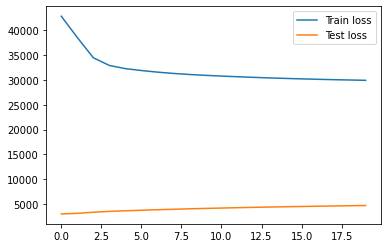

In [44]:
plt.plot(history.history['loss'], label = 'Train loss')
plt.plot(history.history['val_loss'], label = 'Test loss')
plt.legend();

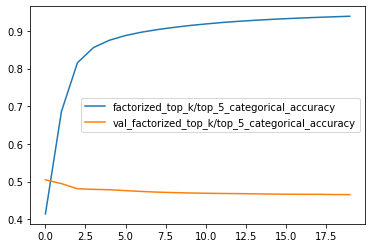

In [45]:
plt.plot(history.history['factorized_top_k/top_5_categorical_accuracy'], label = 'factorized_top_k/top_5_categorical_accuracy')
plt.plot(history.history['val_factorized_top_k/top_5_categorical_accuracy'], label = 'val_factorized_top_k/top_5_categorical_accuracy')
plt.legend();

In [46]:
model.evaluate(cached_train, return_dict=True)

275/275 [==============================] - 156s 562ms/step - factorized_top_k/top_1_categorical_accuracy: 0.4476 - factorized_top_k/top_5_categorical_accuracy: 0.9369 - factorized_top_k/top_10_categorical_accuracy: 0.9769 - factorized_top_k/top_50_categorical_accuracy: 0.9996 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 44870.3026 - regularization_loss: 0.0000e+00 - total_loss: 44870.3026


{'factorized_top_k/top_1_categorical_accuracy': 0.44761940836906433,
 'factorized_top_k/top_5_categorical_accuracy': 0.9369252324104309,
 'factorized_top_k/top_10_categorical_accuracy': 0.9768857955932617,
 'factorized_top_k/top_50_categorical_accuracy': 0.9996156692504883,
 'factorized_top_k/top_100_categorical_accuracy': 1.0,
 'loss': 28255.451171875,
 'regularization_loss': 0,
 'total_loss': 28255.451171875}

In [47]:
model.evaluate(cached_test, return_dict=True)

184/184 [==============================] - 33s 175ms/step - factorized_top_k/top_1_categorical_accuracy: 0.1313 - factorized_top_k/top_5_categorical_accuracy: 0.4652 - factorized_top_k/top_10_categorical_accuracy: 0.6274 - factorized_top_k/top_50_categorical_accuracy: 0.9583 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 39035.6028 - regularization_loss: 0.0000e+00 - total_loss: 39035.6028


{'factorized_top_k/top_1_categorical_accuracy': 0.13129505515098572,
 'factorized_top_k/top_5_categorical_accuracy': 0.4651966989040375,
 'factorized_top_k/top_10_categorical_accuracy': 0.627443253993988,
 'factorized_top_k/top_50_categorical_accuracy': 0.9583055973052979,
 'factorized_top_k/top_100_categorical_accuracy': 0.9999773502349854,
 'loss': 4696.2216796875,
 'regularization_loss': 0,
 'total_loss': 4696.2216796875}

In [48]:
# Use brute-force search to set up retrieval

index = tfrs.layers.factorized_top_k.BruteForce(model.query_model)
index.index(hotel_cluster.batch(1000).map(model.candidate_model), hotel_cluster)

In [49]:
# Recommendation for 1 input

input = {'user_id': tf.constant(['42']),
         'user_location_city': tf.constant(['41898']),
         'is_mobile': tf.constant(['0']),
         'is_package': tf.constant(['0']),
         'channel': tf.constant(['0']),
         'srch_adults_cnt': tf.constant(['2']),
         'srch_children_cnt': tf.constant(['2']),
         'srch_rm_cnt': tf.constant(['1']),
         'srch_destination_id': tf.constant(['53']),
         'hotel_market': tf.constant(['53']),
         'days_to_checkin': tf.constant(['1']),
         'stay_length': tf.constant(['1']),
         'month_of_booking': tf.constant(['4']),
         'month_of_staying': tf.constant(['6']),
         
        }

score, recommend = index(input)

print(f"Top 5 recommendations for user 94390: {recommend[0, :5]}")
print(f'Scores for top 5: {score[0, :5]}')

Top 5 recommendations for user 94390: [b'2' b'61' b'38' b'57' b'78']
Scores for top 5: [ -9.484797 -10.657951 -11.067793 -11.844119 -11.890082]


In [50]:
## model have been ran and saved.

# index.save('../models/TFRS_Full_Dataset/')

In [ ]:
loaded = tf.keras.models.load_model('../models/TFRS_Full_Dataset/')

In [51]:
predictions = convert_tensor_to_mapX_format(index, train)
target = train.map(lambda x: x['hotel_cluster'])
target = list(target.as_numpy_iterator())
target = [[x.decode('utf-8')] for x in target]
print(f'Trainset MAP@5 score: {ml_metrics.mapk(target, predictions, k=5)}')

Trainset MAP@5 score: 0.8070921862912508


In [52]:
predictions = convert_tensor_to_mapX_format(index, test)
target = test.map(lambda x: x['hotel_cluster'])
target = list(target.as_numpy_iterator())
target = [[x.decode('utf-8')] for x in target]
print(f'Testset MAP@5 score: {ml_metrics.mapk(target, predictions, k=5)}')

Testset MAP@5 score: 0.3050001799584896


#### Predict for Kaggle (Only Run if Wanted to save file for Kaggle Submission)

In [53]:
def convert_tensor_to_kaggleformat(index, kaggle):
        
    '''
    Function to map output of BruteForce Layer to Kaggle submission format
    
    '''
       
    submit = kaggle[['id']].copy(deep = True)
    
    df = kaggle.astype(str)
    df = tf.data.Dataset.from_tensor_slices(dict(df))
    
    df = df.map(lambda x: {'user_id': x['user_id'],
                           'user_location_city': x['user_location_city'],
                           'is_mobile': x['is_mobile'],
                           'is_package': x['is_package'],
                           'channel': x['channel'],
                           'srch_adults_cnt': x['srch_adults_cnt'],
                           'srch_children_cnt': x['srch_children_cnt'],
                           'srch_rm_cnt': x['srch_rm_cnt'],
                           'srch_destination_id': x['srch_destination_id'],
                           'hotel_market': x['hotel_market'],
                           'days_to_checkin': x['days_to_checkin'],
                           'stay_length': x['stay_length'],
                           'month_of_booking': x['month_of_booking'],
                           'month_of_staying': x['month_of_staying']
                          }
               )
    
    prediction = pd.DataFrame()
    
    for row in df.batch(8192):
        top = index(row)[1].numpy()[:, :5]
        pred = pd.DataFrame(top).apply(lambda x: ' '.join([x[i].decode('utf-8') for i in range(5)]), axis = 1)               
        prediction = pd.concat([prediction, pred]).reset_index(drop = True)
    
    submit['hotel_cluster']= prediction
    
    return submit

In [54]:
submit = convert_tensor_to_kaggleformat(index, kaggle)
submit.to_csv('../datasets/submission_tfrs_advance_features.csv', index = False)

### 3. Evaluation

We proceeded to fit our model with the full dataset and the model achieved a trainset score of 0.8071 and a testset score of 0.3050. This obviously show overfitting which we can continue to finetune more. We like this model given the fact that despite the fact that we haven't improve on it much but it already achieved a score which put it in 2nd place of all our models and the score is not far away from our top model.

We also like that the model can handle new categories with ease which is a challenge for all our other ML models. Furthermore we can train this model by batches which will sort the issue of out of memory when training with huge datasets. This also means that we do not have to retrain the model when we have need data and we can keep improving the model when we have new data. In addition, the model is one of the models trained the fastest.

This model also have the flexibility to be reconfigured for different requirement. For example as mentioned earlier, our model is configured to recommend hotel cluster based on the user past preferences and searched destination. We can also reconfigure the model to recommend destinations and hotel cluster based on user past preferences by putting destination under the Candidate Model and using the destination dataset to find similarities between destinations.

This model obtain a Kaggle Score of 0.2194.

#### Possible Further improvement

1. Finetune the model to address overfitting using early stopping or regularization
2. Build a multitask TFRS model which include a ranking task.